<font size="10"> Big Contest 2019 </font>

-------------------------------
<br />

# 모델링 

<br />
<br />

다음 모형들에 대해 Grid Search를 진행합니다. 
1. Logistic Regression
2. KNN
3. SVM
4. RandomForest
5. LightGBM
6. CatBoost

**하이퍼파라미터 튜닝 방법**
1. 흔히 쓰는 파라미터로 1차 튜닝
2. 만약 파라미터 범위의 양끝점이 선택된다면 그 지점을 중심으로 한 범위로 2차 튜닝 


앞선 모델링들로 결항을 넣었을 때 AUC가 감소하고 표준편차가 커짐을 확인했기 때문에 Train set에서 결항을 빼고 진행했습니다.
마찬가지의 이유로 제빙작업을 제외하였습니다.

In [118]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime

from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer


# Load Data
df_afsnt = pd.read_csv("df_afsnt_last.csv", encoding = "cp949")
C10date = ['2017-12-18 00:00:00',
 '2019-02-15 00:00:00',
 '2018-11-24 00:00:00',
 '2018-02-04 00:00:00',
 '2017-01-20 00:00:00',
 '2018-01-13 00:00:00',
 '2018-02-23 00:00:00',
 '2018-02-06 00:00:00',
 '2018-01-24 00:00:00',
 '2018-02-05 00:00:00',
 '2018-02-08 00:00:00',
 '2017-02-10 00:00:00',
 '2018-01-26 00:00:00',
 '2017-02-22 00:00:00',
 '2019-01-14 00:00:00',
 '2017-12-07 00:00:00']
df_afsnt = df_afsnt[~((df_afsnt.date.isin(C10date) ==True) & (df_afsnt.cause_delay =='C10'))]

# 시계열 CV를 위한 정렬 
df_afsnt = df_afsnt.sort_values(['year', 'month', 'day'], ascending=[True, True, True])
df_afsnt = df_afsnt.reset_index()
df_afsnt.drop('index', axis = 1, inplace = True)


# 표준화용 변수들
scale_features = ["degree_center_weight_origin", "degree_center_weight_dest", "degree_center_origin", "degree_center_dest", \
                  "distance_km", "distance_center", "distance_center_weight", "lot_area", "main_air", \
                  "sub_air", "air_processing", "terminal_width", "terminal_ability"]

# OneHotEncoding Features
ohe_features = ['wday', 'airline', 'time_discrete']

preprocess = make_column_transformer(
    #(StandardScaler(), scale_features),
    (OneHotEncoder(sparse = False, handle_unknown ='ignore'), ohe_features), remainder = "passthrough"
)

# CV Class
class BigconTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
        
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y = None, groups = None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        
        # fold마다 margin을 달리 잡는다.
        margin = 1050*77
        start = 0
        stop = 0 
        # 17년 6월, 17년 9월, 18년 6월, 18년 9월, 19년 6월을 val set으로 잡았다.
        # fold2와 fold4는 17년 9월15일, 18년 9월 27일이 val set의 시작이다.
        mid = [1050*30*6, 1050*30*9 - 1050*3, 1050*30*18, 1050*30*21 + 1050*20, 5 * k_fold_size - 1050*15]
        stop = [1050*30*6 + 1050*15, 1050*30*9 + 1050*15 - 1050*3, 1050*30*18 + 1050*15, 1050*30*21 + 1050*15 + 1050*20, 5 * k_fold_size]
        for i in range(self.n_splits):
            #stop = (i + 1) *  k_fold_size
            #mid = stop - 1050*15
            yield indices[start:mid[i] - margin], indices[mid[i]: stop[i]]
 

random_state = 8282
bts_cv = BigconTimeSeriesSplit(n_splits=5)

# 결항데이터 제거용
# y_cancel = pd.Series(np.where(df_afsnt_total['is_cancel'] == True, True, False))
# idx_cancel = y_cancel[y_cancel == True].index

df_afsnt.drop(['month','day','flight','origin','dest','cause_cancel','tailnum','cause_delay','sched_time','real_time',
        'is_cancel', 'is_regular', 'date','sched_datetime','real_datetime','delay', 'origin_dest', 'pred_dew'], axis=1, inplace=True)

y = df_afsnt['is_delay']
X = df_afsnt.iloc[:, df_afsnt.columns != 'is_delay']

In [25]:
def bts_cv_model_auc(clf):
    print("모델을 훈련합니다.")
    tprs = []
    aucs = []
    rmses = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold_num, (train_idx, val_idx) in enumerate(bts_cv.split(X, y), 1):
            # Fold의 피팅 시작시간 
            start_time = datetime.now()

            X_train, y_train = X.iloc[train_idx, :], y.loc[train_idx]
            X_val, y_val = X.iloc[val_idx, :], y.loc[val_idx]

            # 훈련
            probas_ = pd.DataFrame({'idx_val': val_idx, 'prob': clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]})               

    #         # 종속변수의 결항데이터 제거 
    #         val_idx = list(np.setdiff1d(val_idx, idx_cancel))
    #         probas_ = probas_[probas_.isin(val_idx)['idx_val']]
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y_val, probas_.iloc[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (fold_num, roc_auc))

            # Fold의 피팅 소요시간 
            time_elapsed = datetime.now() - start_time
            print('{0} Fold fitting time (hh:mm:ss.ms) {1}'.format(fold_num, time_elapsed))


    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## LogisticRegression: Ridge

In [5]:
clf_lr = RidgeClassifier(random_state = random_state)

params= {'clf__alpha': [0.00001, 0.00005, 0.0001, 0.0005]}
pipe_lr = Pipeline([
    ('preprocess', preprocess), 
    ('clf', RidgeClassifier(random_state = random_state))
    ])
gs = GridSearchCV(rdg_reg, params, cv = bts_cv, scoring = 'roc_auc')
%time gs.fit(X, y)
print(gs.best_score_)
best_params_lr = gs.best_params_
print(gs.best_params_)

clf_lr = RidgeClassifier(**best_params_lr)

Wall time: 2min 31s
0.6992755457063583
{'clf__alpha': 1e-05}


In [5]:
pipe_lr = Pipeline([
    ('preprocess', preprocess), 
    ('clf', LogisticRegression(random_state = random_state, solver = "lbfgs"))
    ])

모델을 훈련합니다.


C:\Users\user123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


1 Fold fitting time (hh:mm:ss.ms) 0:00:04.336389


C:\Users\user123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


2 Fold fitting time (hh:mm:ss.ms) 0:00:08.526118


C:\Users\user123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


3 Fold fitting time (hh:mm:ss.ms) 0:00:22.325399


C:\Users\user123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


4 Fold fitting time (hh:mm:ss.ms) 0:00:28.545863


C:\Users\user123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


5 Fold fitting time (hh:mm:ss.ms) 0:00:41.049000


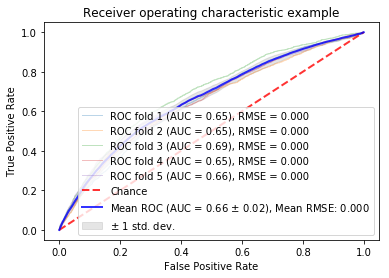

In [6]:
bts_cv_model_auc(pipe_lr)

ridge는 효과가 없다고 판단되므로 일반적인 로지스틱 회귀를 사용하였다.

## KNN

In [11]:
clf_knn = KNeighborsClassifier()

param_grid = {
    'clf__n_neighbors': [61, 64, 67, 70, 73, 76, 79, 82],
    'clf__weights': ['distance'],
    'clf__metric': ['euclidean', 'manhattan']
}
pipe_knn = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_knn)
    ])
gs = GridSearchCV(estimator=pipe_knn, param_grid = param_grid, scoring = 'roc_auc', cv= bts_cv)
%time gs.fit(X, y)
print(gs.best_score_)
best_params_knn = gs.best_params_
print(gs.best_params_)



Wall time: 1h 20min 59s
0.7110278141729652
{'clf__metric': 'manhattan', 'clf__n_neighbors': 76, 'clf__weights': 'distance'}


In [2]:
clf_knn = KNeighborsClassifier(metric = "manhattan", n_neighbors = 76, weights = 'distance', solver = "lbfgs")
pipe_knn = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_knn)
    ])

## SVM

SVM은 워낙 오래걸려서 생략

In [13]:
clf_svm = SVC(random_state = random_state)

param_grid = {'clf__C': [0.01, 0.1, 1, 10], 'clf__gamma': [1, 0.1, 0.01, 0.001], 'clf__kernel': ['rbf']}
pipe_svc = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_svm)
    ])

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = 'roc_auc', cv= bts_cv, random_state = random_state, n_jobs = -1)
%time gs.fit(X, y)
print(gs.best_score_)
best_params_svm = gs.best_params_
print(gs.best_params_)

clf_svm = SVC(**best_params_svm)

C:\Users\quasa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: '일'

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [8]:
clf_svm = SVC(C = 1, random_state = random_state, kernel = "linear")
pipe_svc = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_svm)
    ])

KeyboardInterrupt: 

## RandomForest

In [11]:
clf_rf = RandomForestClassifier(random_state = random_state)

param_grid = {
    'clf__n_estimators'      : [500],
    'clf__max_depth'         : [5, 7,  9, 11],
    'clf__max_features'      : [10,11, 12]
}   
pipe_rf = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_rf)
    ])
gs = GridSearchCV(estimator = pipe_rf, cv = bts_cv,
                param_grid = param_grid, scoring= 'roc_auc', n_jobs = -1)
%time gs.fit(X, y)
print(gs.best_score_)
best_params_rf = gs.best_params_
print(gs.best_params_)

clf_rf = RandomForestClassifier(**best_params_rf)

exception calling callback for <Future at 0x1ad4f5b8f28 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\quasa\Anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\quasa\Anaconda3\lib\site-packages\joblib\parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\quasa\Anaconda3\lib\site-packages\joblib\parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\quasa\Anaconda3\lib\site-packages\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\quasa\Anaconda3\lib\site-packages\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\quasa\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [4]:
clf_rf = RandomForestClassifier( n_estimators = 500, max_depth = 11, max_features = 12, random_state = random_state)
pipe_rf = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_rf)
    ])

## LightGBM

lightgbm과 catboost는 따로 categorical variable을 control가능하므로 preprocess를 새로 정의하였다.

lightgbm은 범주형 변수를 int로 변환시킨뒤 categorical_feature로 전달해야한다.

Grid Search가 지나치게 오래 걸리므로 대안으로서 [Bayesian Optimization](https://medium.com/vantageai/bringing-back-the-time-spent-on-hyperparameter-tuning-with-bayesian-optimisation-2e21a3198afb)을 제안합니다.

여기도 참고하세요. [Hyperparmeter Tuning](https://dkopczyk.quantee.co.uk/hyperparameter-optimization/)

In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, pyll
import numpy as np
from time import time
from sklearn.model_selection import cross_val_score


param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1000, 2000, 50)),
    'num_leaves': pyll.scope.int(hp.quniform('num_leaves', 20, 80, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

trials = Trials()


def hyperopt(param_space, X_train, y_train, num_eval, X_test = None, y_test = None):
    
    preprocess_lgb = make_column_transformer(
    (StandardScaler(), scale_features),
    (OneHotEncoder(sparse = False, handle_unknown ='ignore'), ohe_features),
    remainder = "passthrough" # ohe를 하지는 않지만 동일한 feature에 대해 적용하므로 해당 변수를 사용
    )

    X_train = preprocess_lgb.fit_transform(X_train)
    #X_test = preprocess_lgb.fit_transform(X_test)
    
    start_time = datetime.now()
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(random_state = random_state, **params)
        score = cross_val_score(clf, X_train, y_train, scoring = "roc_auc", cv = bts_cv).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
#     if best_param_values[0] == 0:
#         boosting_type = 'gbdt'
#     else:
#         boosting_type= 'dart'

#     clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
#                                   num_leaves=int(best_param_values[5]),
#                                   max_depth=int(best_param_values[3]),
#                                   n_estimators=int(best_param_values[4]),
#                                   boosting_type=boosting_type,
#                                   colsample_bytree=best_param_values[1],
#                                   reg_lambda=best_param_values[6],
#                                  )

#    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
#    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", datetime.now() - start_time)
    print("Parameter combinations evaluated: ", num_eval)
                                      
    
    return trials


num_eval = 50

results_hyperopt = hyperopt(param_hyperopt, X, y, num_eval)

# clf_lgb = lgb.LGBMClassifier(objective='binary', categorical_feature = cat_features_,
#                          random_state = random_state, silent=True, metric='None', **best_param)

100%|██████████| 50/50 [25:52:44<00:00, 1838.54s/it, best loss: -0.7882584816221347]   

##### Results
Score best parameters:  0.7882584816221347
Best parameters:  {'boosting_type': 1, 'colsample_by_tree': 0.6533437523326235, 'learning_rate': 0.04160534135601695, 'max_depth': 19.0, 'n_estimators': 2000.0, 'num_leaves': 35.0, 'reg_lambda': 0.5508858320081631}
Time elapsed:  1 day, 1:52:44.530622
Parameter combinations evaluated:  50


In [119]:
clf_lgb = lgb.LGBMClassifier(**{'colsample_by_tree': 0.6533437523326235, 'learning_rate': 0.04160534135601695, 
                              'max_depth': 19, 'n_estimators': 2000, 'num_leaves': 35, 'reg_lambda': 0.5508858320081631, 'class_weight': 'balanced'})
pipe_lgb = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_lgb)
    ])

# bts_cv_model_auc(pipe_lgb)

In [120]:
X['is_arrive'] = np.where(X['is_arrive'] == True, 1, 0)
X['is_weekend'] = np.where(X['is_weekend'] == True, 1, 0)
X['is_goldentime'] = np.where(X['is_goldentime'] == True, 1, 0)

C:\Users\quasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\quasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\quasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [121]:
y = y.astype(int)

for fold_num, (train_idx, val_idx) in enumerate(bts_cv.split(X, y), 1):
    if fold_num == 5:
        X_train, y_train = X.iloc[train_idx, :], y.loc[train_idx]
        X_val, y_val = X.iloc[val_idx, :], y.loc[val_idx]

preprocess_lgb = make_column_transformer(
    (StandardScaler(), scale_features),
    (OneHotEncoder(sparse = False, handle_unknown ='ignore'), ohe_features),
    remainder = "passthrough" # ohe를 하지는 않지만 동일한 feature에 대해 적용하므로 해당 변수를 사용
    )

ohe = OneHotEncoder(sparse = False)
X_train_ohe = ohe.fit_transform(X_train[ohe_features])
columns_names = ohe.get_feature_names()
X_train_ohe = pd.DataFrame(X_train_ohe, columns = columns_names)

X_val_ohe = ohe.fit_transform(X_val[ohe_features])
columns_names = ohe.get_feature_names()
X_val_ohe = pd.DataFrame(X_val_ohe, columns = columns_names)



In [122]:
X_train = pd.concat([X_train.iloc[:, ~X_train.columns.isin(ohe_features)], X_train_ohe], axis = 1)

X_val = X_val.reset_index()
X_val.drop('index', axis = 1, inplace = True)
X_val = pd.concat([X_val.iloc[:, ~X_val.columns.isin(ohe_features)], X_val_ohe], axis = 1)

In [123]:
clf_lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_by_tree=0.6533437523326235, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.04160534135601695,
               max_depth=19, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=35,
               objective=None, random_state=None, reg_alpha=0.0,
               reg_lambda=0.5508858320081631, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [129]:
clf_lgb.feature_importances_

array([1802,  989,  331, 1370, 1415,   17,    0,   10, 2642, 2264,  473,
       2092, 2202,  407,  480,  483,  587,  188,  270, 1092,   81,   91,
        152,  352,  199,   18,  230,  120, 1977, 2696, 2822,  553, 2471,
       1345, 5964, 2277,  519,  846, 6111, 4666, 3046, 2876, 3270,  524,
        470,  676,  440,  537,  643,  485,  308,  315,  196,  342,  383,
        391,  379,    0,   65,    0,    9,    4,    0,   37])

In [130]:
clf_lgb.

'split'

In [ ]:
feat_importances = pd.Series(clf_lgb.feature_importances_, index=X_train.columns)
sns.barplot(x=feat_importances, y=X_train.columns)

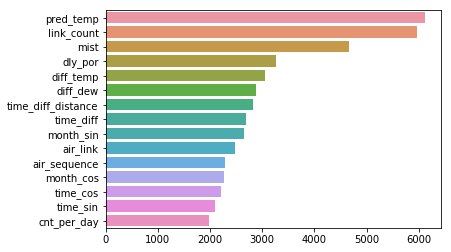

In [134]:
feat_importances = pd.Series(clf_lgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15)
sns.barplot(x=feat_importances.nlargest(15).values, y=feat_importances.nlargest(15).index)

In [124]:
import shap  # package used to calculate Shap values

# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf_lgb)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val)

# explain the model's predictions using SHAP values
shap.summary_plot(shap_values, X_val, show = False)

ValueError: cannot reshape array of size 1023750 into shape (15750,1,64)

In [12]:
preprocess_lgb = make_column_transformer(
    (StandardScaler(), scale_features),
    remainder = "passthrough" # ohe를 하지는 않지만 동일한 feature에 대해 적용하므로 해당 변수를 사용
    )

X2 = preprocess_lgb.fit_transform(X)
X2.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [14]:
X2[0]

array([-1.7403103126681463, 0.2674672975287493, -1.8767099270075638,
       0.9929393011081867, -1.1056917292582775, -1.9542847222697994,
       1.9627988553599414, -1.6393246093071736, -0.9137853164207179,
       0.4001557660221358, -1.061205929150303, -1.929026894838933,
       -1.7807709092013244, 2017, 1, '8시-11시', '일', '아시아나', False, False,
       2, 0, 0, 0, 0.5, 0.8660254037844387, True, 42.42640687119285,
       -41.42640687119285, 12.8, 18.0, 80, 0.2948113207547169, '광주,김포', 1,
       False, 16, 0, 6.706264434180138, 1, 0], dtype=object)

In [ ]:
cat_features_= [15, 16, 17] # 계속 바뀜

param_grid = {'clf__depth': [10, 12, 14],
          'clf__learning_rate' : [0.03, 0.02, 0.01],
         'clf__l2_leaf_reg': [9,11,13],
         'clf__iterations': [500, 750]}
clf_cb = cb.CatBoostClassifier(cat_features = cat_features_, random_state = random_state, verbose = 0)



preprocess_cb = make_column_transformer(
    (StandardScaler(), scale_features), remainder = "passthrough"
)

pipe_cb = Pipeline([
    ('preprocess', preprocess_cb),
    ('clf', clf_cb)
    ])

gs = GridSearchCV(pipe_cb, param_grid, scoring = "roc_auc", cv = bts_cv, n_jobs = -1, verbose = 0)

y = y.astype(int)

%time gs.fit(X, y)

# print("PERFORMANCE IMPROVES FROM TOP TO BOTTOM")
# print("Valid+-Std     Train  :   Parameters")
# for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
#     print('{1:.3f}+-{3:.3f}  :  {0}'.format(gs.cv_results_['params'][i], 
#                                     gs.cv_results_['mean_test_score'][i], 
#                                     gs.cv_results_['std_test_score'][i]))

# best_params_cb = gs.best_params_

# # one_hot_max_size tuning
# param_grid_oh = {"clf__one_hot_max_size": [7, 8, 15, 84, 91, 92, 99]}

# clf_cb = cb.CatBoostClassifier(cat_features = cat_features_, random_state = random_state)
# pipe_cb = Pipeline([
#     ('preprocess', preprocess_cb),
#     ('clf', clf_cb)
#     ])

# gs = GridSearchCV(pipe_cb, param_grid_cb, scoring = "roc_auc", cv = bts_cv)

# %time gs.fit(X, y)

# print("PERFORMANCE IMPROVES FROM TOP TO BOTTOM")
# print("Valid+-Std     Train  :   Parameters")
# for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
#     print('{1:.3f}+-{3:.3f}  :  {0}'.format(gs.cv_results_['params'][i], 
#                                     gs.cv_results_['mean_test_score'][i], 
#                                     gs.cv_results_['std_test_score'][i]))
    
# best_params_cb_oh = gs.best_params_

# clf_cb = cb.CatBoostClassifier(**best_params_cb)

In [7]:
np.mean(df_afsnt['is_delay'])

0.12095270687867442

모델을 훈련합니다.
1 Fold fitting time (hh:mm:ss.ms) 0:05:26.194925
2 Fold fitting time (hh:mm:ss.ms) 0:08:15.308434
3 Fold fitting time (hh:mm:ss.ms) 0:16:32.442450
4 Fold fitting time (hh:mm:ss.ms) 0:21:53.384471
5 Fold fitting time (hh:mm:ss.ms) 0:29:40.174969


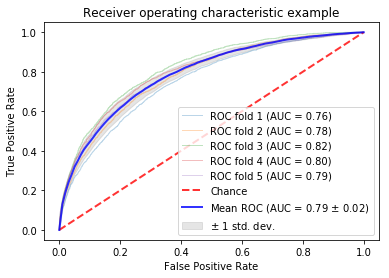

In [13]:
cat_features_= [15, 16, 17]
clf_cb = cb.CatBoostClassifier(class_weights = [0.88, 0.12], cat_features = cat_features_, random_state = random_state, verbose = 0,
                              learning_rate = 0.03, depth = 12, l2_leaf_reg = 9, iterations = 750)
y = y.astype(int)

preprocess_cb = make_column_transformer(
    (StandardScaler(), scale_features), remainder = "passthrough"
)

pipe_cb = Pipeline([
    ('preprocess', preprocess_cb),
    ('clf', clf_cb)
    ])

bts_cv_model_auc(pipe_cb)

{"clf__depth": 10, clf__iterations": 500, "clf__l2_leaf_reg": 9, 'clf__iterations': 0.03}

# Voting


Trainining set과 Validation set의 차이가 77일이고 Validation set의 길이가 15일인 Time Series Cross Validation을 수행합니다.

다음 모델들에 대해 Hard Voting을 수행합니다.
1. Logistic Regression
2. KNN
3. RandomForest
4. LightGBM
5. CatBoost

각 Fold의 전체 Validation Set으로 예측한 뒤, Validation Set의 결항 데이터를 제거하여 평가합니다.

1 Fold fitting time (hh:mm:ss.ms) 0:03:04.022929
2 Fold fitting time (hh:mm:ss.ms) 0:09:45.138759
3 Fold fitting time (hh:mm:ss.ms) 0:17:08.808624
4 Fold fitting time (hh:mm:ss.ms) 0:26:26.076542


MemoryError: Unable to allocate array with shape (882825, 128) and data type float64

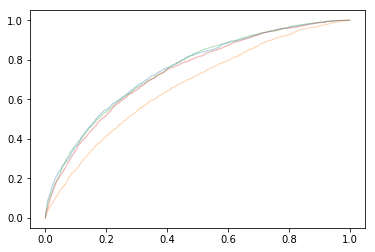

In [11]:
print(__doc__)
from sklearn.ensemble import VotingClassifier
'''
Trainining set과 Validation set의 차이가 77일이고 Validation set의 길이가 15일인 Time Series Cross Validation을 수행합니다.

다음 모델들에 대해 Hard Voting을 수행합니다.
1. Logistic Regression
2. KNN
3. RandomForest
4. LightGBM
5. CatBoost

각 Fold의 전체 Validation Set으로 예측한 뒤, Validation Set의 결항 데이터를 제거하여 평가합니다.
'''

pipe_voting = Pipeline([['clf_voting', 
                                 VotingClassifier(estimators = [
                                            ('lr', pipe_lr), 
                                            ('knn', pipe_knn), 
                                            ('rf', pipe_rf),
                                            ('lgb', pipe_lgb),
                                            ('cb', pipe_cb)
                                        ], voting = 'soft',
                            n_jobs = -1)]])


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
rmse_list = []

for fold_num, (train_idx, val_idx) in enumerate(bts_cv.split(X, y), 1):
        # Fold의 피팅 시작시간 
        start_time = datetime.now()
        
        X_train, y_train = X.iloc[train_idx, :], y.loc[train_idx]
        X_val, y_val = X.iloc[val_idx, :], y.loc[val_idx]
        
        # 훈련
        probas_ = pd.DataFrame({'val_idx_': val_idx, 'prob': pipe_voting.fit(X_train, y_train).predict_proba(X_val)[:, 1]})               
        
        # 종속변수의 결항데이터 제거 
        # val_idx = list(np.setdiff1d(val_idx, idx_cancel))
        # probas_ = probas_[probas_.isin(val_idx)['val_idx_']]
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_val, probas_.iloc[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # RMSE
#         rmse = np.sqrt(np.sum(np.square(y_val - probas_['prob'])))
#         rmse_list.append(rmse)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold {0} (AUC = {1:.2})'.format(fold_num, roc_auc))
        
        # Fold의 피팅 소요시간 
        time_elapsed = datetime.now() - start_time
        print('{0} Fold fitting time (hh:mm:ss.ms) {1}'.format(fold_num, time_elapsed))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# mean_rmse = np.mean(rmse_list)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = {.2:0} $\pm$ {.2:1})'.format(mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Shapley Value

In [71]:
X_val

,year,congestion_15,is_arrive,congestion,link,is_flight_T,is_flight_M,is_flight_F,month_sin,month_cos,...,x1_이스타,x1_제주항공,x1_진에어,x1_티웨이,x2_11시-14시,x2_14시-17시,x2_17시-20시,x2_20시-23시,x2_5시-8시,x2_8시-11시
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
import shap  # package used to calculate Shap values

# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf_lgb)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val)

# explain the model's predictions using SHAP values
shap.summary_plot(shap_values, X_val, show = False)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields time_discrete, wday, airline, origin_dest

# Submission

---

**NOTE**

코리안익스프레스는 Train에 존재하지 않고 Test에 존재하므로 
모델 기반 결측치 대치 방법을 사용한다.

---

In [8]:
import pandas as pd
from sklearn.ensemble import VotingClassifier

df_test = pd.read_csv("test_last.csv", encoding = "cp949")
df_test = df_test.iloc[:, df_test.columns.isin(X.columns)] # X와 변수를 맞추기위해
df_test['airline'] = np.where(df_test['airline'] == "코리아익스프레스에어", "진에어", df_test['airline'] )
df_test = df_test[X.columns]

clf_lgb = lgb.LGBMClassifier(**{'boosting_type': 'dart', 'colsample_by_tree': 0.6533437523326235, 'learning_rate': 0.04160534135601695, 
                              'max_depth': 19, 'n_estimators': 2000, 'num_leaves': 35, 'reg_lambda': 0.5508858320081631, 'class_weight': 'balanced'})
pipe_lgb = Pipeline([
    ('preprocess', preprocess), 
    ('clf', clf_lgb)
    ])


prob = pipe_lgb.fit(X, y)
df_test['DLY_RATE'] = prob.predict_proba(df_test)[:, 1]
df_test['DLY'] = prob.predict(df_test)
df_test

NameError: name 'make_column_transformer' is not defined

In [9]:
df_test.to_csv("df_test2.csv", index = False)